# Simulate data for multidms

Jesse developed a pipeline to simulate DMS data to test `dms_variants`. This involved simulating data for a single homolog. Below, to test `multidms`, we simulate data for two homologs, introducing shifts in mutational effects at a subset of sites.

## Import `Python` modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks', font_scale=1.5, palette='colorblind')

import Bio.Seq
import collections
import itertools
import random
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP, AAS_NOSTOP, AA_TO_CODONS, AAS_WITHSTOP

## Simulate sequences and mutational effects for two homologs, introducing shifts at a subset of sites

First, simulate the sequence of the first homolog.

In [2]:
genelength = 50  # gene length in codons
random.seed(1)
geneseq_h1 = "".join(random.choices(CODONS_NOSTOP, k=genelength))
aaseq_h1 = str(Bio.Seq.Seq(geneseq_h1).translate())
print(f"Wildtype gene of {genelength} codons:\n{geneseq_h1}")
print(f"Wildtype protein:\n{aaseq_h1}")

Wildtype gene of 50 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGTTTTTCGACTCCAGTAGGTTTACGCTCAGGA
Wildtype protein:
RSVILRAYTNSRVKRVILCNNDLPIRNIRLMMILHNSDASFSTPVGLRSG


Simulate latent mutational effects for the first homolog, storing data in a `SigmoidPhenotypeSimulator` object. Also create an identical object for the second homolog. Below, we will update this object to include shifted mutational effects.

In [3]:
seed = 2
p_sim_h1 = dms_variants.simulate.SigmoidPhenotypeSimulator(geneseq_h1, seed=seed)
p_sim_h2 = dms_variants.simulate.SigmoidPhenotypeSimulator(geneseq_h1, seed=seed)

Plot the distribution of mutation effects for the first homolog.

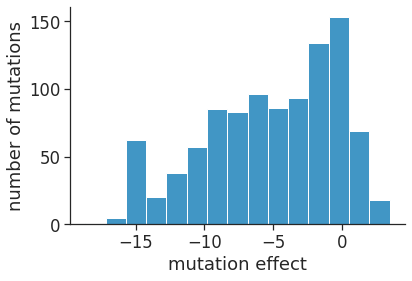

In [4]:
sns.histplot(p_sim_h1.muteffects)
plt.xlabel('mutation effect')
plt.ylabel('number of mutations')
sns.despine()
plt.show()

Next, simulate the DNA/protein sequence of second homolog by making a defined number of random amino-acid mutations to the first homolog. Avoid mutations that decrease the latent phenotype by more than two units.

In [5]:
# Input params
nmuts = 10 # number of amino-acid mutations separating homologs
min_muteffect = -2 # minimum effect per mutation
random.seed(5)
non_identical_sites = sorted(random.sample(range(1, len(aaseq_h1)+1), nmuts))
aaseq_h2 = ''
geneseq_h2 = ''

# Iterate over each amino acid in the first homolog, and make
# a mutation if indicated.
for (aa_n, aa) in enumerate(aaseq_h1, 1):
    codon = geneseq_h1[(aa_n-1)*3:3*aa_n]
    if aa_n in non_identical_sites:
        mut_aas = [
            mut_aa for mut_aa in AAS_NOSTOP
            if (mut_aa != aa) and (p_sim_h1.muteffects[f'{aa}{aa_n}{mut_aa}'] > min_muteffect)
        ]
        assert len(mut_aas) > 0, aa_n
        mut_aa = random.choice(mut_aas)
        aaseq_h2 += mut_aa
        mut_codon = random.choice(AA_TO_CODONS[mut_aa])
        geneseq_h2 += mut_codon
    else:
        aaseq_h2 += aa
        geneseq_h2 += codon

# Store and summarize results
homolog_seqs = {
    1 : aaseq_h1,
    2 : aaseq_h2
}
n_diffs = sum([aa1 != aa2 for (aa1, aa2) in zip(aaseq_h1, aaseq_h2)])
print('Sequence alignment of homologs h1 and h2:')
print('h1', aaseq_h1)
print('h2', aaseq_h2)
print('Number of aa differences:', n_diffs)
assert len(aaseq_h1) == len(aaseq_h2)
assert aaseq_h2 == str(Bio.Seq.Seq(geneseq_h2).translate())
assert n_diffs == len(non_identical_sites)

Sequence alignment of homologs h1 and h2:
h1 RSVILRAYTNSRVKRVILCNNDLPIRNIRLMMILHNSDASFSTPVGLRSG
h2 RVVILRAYTNSRVKRIKLCNNDRPIRNIRTMMIEHNSDAKFHTPYGLDSG
Number of aa differences: 10


Next, randomly choose a subset of sites that will have shifted mutational effects. Do this independently for sites that are identical and non-identical between homologs, so that we are sure to have shifted sites in each category.

In [6]:
# Non-identical sites
random.seed(1)
n_shifted_non_identical_sites = 3
shifted_non_identical_sites = sorted(random.sample(
    non_identical_sites,
    n_shifted_non_identical_sites
))

# Identical sites
n_shifted_identical_sites = 10
identical_sites = [
    i for i in range(1, len(aaseq_h1)+1)
    if i not in non_identical_sites
]
shifted_identical_sites = sorted(random.sample(
    identical_sites,
    n_shifted_identical_sites
))

# Make a list of all shifted sites
shifted_sites = sorted(shifted_identical_sites + shifted_non_identical_sites)
assert len(shifted_sites) == len(set(shifted_sites))
print('Sites with shifts that are...')
print(f'identical (n={len(shifted_identical_sites)}):', ', '.join(map(str, shifted_identical_sites)))
print(f'non-identical (n={len(shifted_non_identical_sites)}):', ', '.join(map(str, shifted_non_identical_sites)))

Sites with shifts that are...
identical (n=10): 3, 8, 9, 15, 29, 35, 37, 38, 47, 49
non-identical (n=3): 16, 17, 30


At each of the above sites, randomly simulate a shift in the effect of each mutation by drawing shifts from a Gaussian distribution.

In [7]:
# TODO possibly have different rate parameters for each site.
def sim_mut_shift(shifted_site, mutation):
    if (not shifted_site) or ('*' in mutation):
        return 0
    else:
        return np.random.normal(loc=0, scale=1.5, size=1)[0]

In [8]:
# Make a dataframe of mutation effects in the first homolog
mut_effects_df = pd.DataFrame.from_dict(
    p_sim_h1.muteffects,
    orient='index',
    columns=['beta_h1']
)
mut_effects_df.reset_index(inplace=True)
mut_effects_df.rename(columns={'index':'mutation'}, inplace=True)
mut_effects_df['wt_aa'] = mut_effects_df['mutation'].str.extract(r'([\w*])\d+[\w*]')
mut_effects_df['site'] = mut_effects_df['mutation'].str.extract(r'[\w*](\d+)[\w*]')
mut_effects_df['site'] = mut_effects_df['site'].astype(int)
mut_effects_df['mut_aa'] = mut_effects_df['mutation'].str.extract(r'[\w*]\d+([\w*])')

# Simulate shifts for all mutations in the pre-defined
# list of shifted sites, ignorning mutations to stop codons
mut_effects_df['shifted_site'] = mut_effects_df['site'].apply(
    lambda x: x in shifted_sites
)
np.random.seed(5)
mut_effects_df['shift'] = mut_effects_df.apply(
    lambda row: sim_mut_shift(
        row['shifted_site'],
        row['mutation']
    ),
    axis=1
)

# Add column that gives mutation effects in the second homolog
mut_effects_df['beta_h2'] = mut_effects_df['beta_h1'] + mut_effects_df['shift']

# Add columns that give the wildtype amino acids of
# each homolog at each site
for (homolog, seq) in homolog_seqs.items():
    seq_dict = {
        key : []
        for key in ['site', f'aaseq_h{homolog}']
    }
    for (i, aa) in enumerate(seq, 1):
        seq_dict['site'].append(i)
        seq_dict[f'aaseq_h{homolog}'].append(aa)
    seq_df = pd.DataFrame.from_dict(seq_dict)
    mut_effects_df = mut_effects_df.merge(seq_df, on='site')

# Show data for a subset of sites with shifts
mut_effects_df[mut_effects_df['shifted_site'] == True][[
    'site', 'aaseq_h1', 'aaseq_h2', 'mutation',
    'beta_h1', 'shift', 'beta_h2',
    'shifted_site'
]].head()

,site,aaseq_h1,aaseq_h2,mutation,beta_h1,shift,beta_h2,shifted_site
40,3,V,V,V3A,-0.229415,0.661841,0.432426,True
41,3,V,V,V3C,-2.954488,-0.496305,-3.450793,True
42,3,V,V,V3D,-1.227970,3.646157,2.418187,True
43,3,V,V,V3E,-4.041836,-0.378138,-4.419974,True
44,3,V,V,V3F,-4.918138,0.164415,-4.753723,True


Plot the distribution of all simulated shifts, excluding mutations to stop codons and sites that have no shifted effects.

Number of mutations with shifts: 247


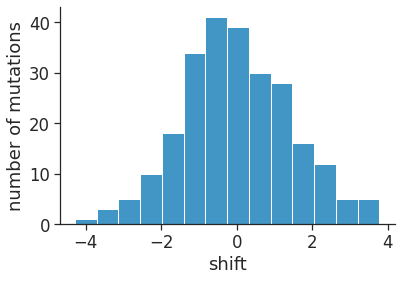

In [9]:
data = mut_effects_df[
    (mut_effects_df['site'].isin(shifted_sites)) &
    ~(mut_effects_df['mutation'].str.contains('\*'))
]
print('Number of mutations with shifts:', len(data))
sns.histplot(data['shift'])
plt.xlabel('shift')
plt.ylabel('number of mutations')
sns.despine()
plt.show()

Above, we created a `SigmoidPhenotypeSimulator` object for the second homolog by making a copy of the one for the first homolog. This object stores the homolog's wildtype latent phenotype and the latent effects of individual mutations. Below, we update both of these traits based on the simulated shifts from above. To update the wildtype latent phenotype, we will add the effects of all mutations that separate the homologs. In computing this sum, we will use $\beta$ parameters for the second homolog, which already include shifted effects.

In [10]:
# Update individual mutational effects
assert sum(mut_effects_df['mutation'].duplicated()) == 0
for mutation in p_sim_h2.muteffects.keys():
    p_sim_h2.muteffects[mutation] = float(mut_effects_df[mut_effects_df['mutation']==mutation]['beta_h2'])

# Update the wildtype latent phenotype
data = mut_effects_df[
    (mut_effects_df['site'].isin(non_identical_sites)) &
    (mut_effects_df['mut_aa'] == mut_effects_df['aaseq_h2'])
]
wt_latent_phenotype_shift = sum(data['beta_h2'])
p_sim_h2.wt_latent = p_sim_h1.wt_latent + wt_latent_phenotype_shift
print('Characteristics of mutations separating homologs:')
for metric in ['beta_h1', 'shift', 'beta_h2']:
    print(f'Sum of {metric}:', round(sum(data[metric]), 2))
print('Final WT latent phenotype of h2:', round(p_sim_h2.wt_latent, 2))
print('Table of mutations that separate homologs:')
data[[
    'site', 'aaseq_h1', 'aaseq_h2', 'mutation',
    'beta_h1', 'shift', 'beta_h2',
    'shifted_site', 
]]

Characteristics of mutations separating homologs:
Sum of beta_h1: 3.41
Sum of shift: -2.8
Sum of beta_h2: 0.61
Final WT latent phenotype of h2: 5.61
Table of mutations that separate homologs:


,site,aaseq_h1,aaseq_h2,mutation,beta_h1,shift,beta_h2,shifted_site
36,2,S,V,S2V,1.183358,0.000000,1.183358,False
307,16,V,I,V16I,-0.023267,1.165361,1.142094,True
327,17,I,K,I17K,2.563328,-2.630611,-0.067283,True
453,23,L,R,L23R,1.338062,0.000000,1.338062,False
595,30,L,T,L30T,-0.159066,-1.334131,-1.493197,True
663,34,L,E,L34E,1.691220,0.000000,1.691220,False
788,40,S,K,S40K,-0.419165,0.000000,-0.419165,False
826,42,S,H,S42H,-1.988213,0.000000,-1.988213,False
898,45,V,Y,V45Y,-0.651130,0.000000,-0.651130,False
942,48,R,D,R48D,-0.122808,0.000000,-0.122808,False


All mutations in the second homolog's `SigmoidPhenotypeSimulator` object are defined relative to the wildtype sequence of the first homolog, which we will call the "reference" homolog.
But, to simulate data for the second homolog, we need entries to be relative to the wildtype sequence of the second homolog.
These entries are missing for sites at which the homologs differ in sequence.
For instance, if the wildtype amino acid at site 30 is an A in the first homolog, but is a Y in a second homolog, then the effect of a Y30G is absent from the second homolog's simulator object.

To add these missing entries, we will use a strategy that assumes additivity between mutations at the same site.
For instance, in the above example, a Y30G mutation is defined as the sum of the following two mutations relative to A: A30Y (negated) and A30G.
This approach assumes that mutational effects can be negated, such that A30Y has the opposite effect as Y30A.
It also assumes that mutational effects are additive, such that the effect of Y30G is the sum of the effects of Y30A and A30G.

The below expression defines this approach more explicitly for an arbitrary site.
It uses the notation $\beta_{x,n,z}$ where $x$ and $z$ are amino acids.
For a site $n$, if $aa_{\text{wt}}$ is the site's wildtype amino acid in a non-reference homolog, $aa_{\text{mut}}$ is a mutant amino acid in a variant of that homolog, and $aa_{\text{ref}}$ is the site's wildtype amino acid in the reference homolog, then the mutation's effect is:

$$\beta_{aa_{\text{wt}},n,aa_{\text{mut}}} = \begin{cases}
      \beta_{aa_{\text{ref}},n,aa_{\text{mut}}} & \text{if } aa_{\text{wt}} = aa_{\text{ref}}\\
      -\beta_{aa_{\text{ref}},n,aa_{\text{wt}}} & \text{if } aa_{\text{mut}} = aa_{\text{ref}}\\
      - \beta_{aa_{\text{ref}},n,aa_{\text{wt}}} +\beta_{aa_{\text{ref}},n,aa_{\text{mut}}} & \text{otherwise}\\
\end{cases}$$

The above $\beta$ parameters are effects in the background of the non-reference homolog, such that they account for shifts in mutational effects between homologs.

The below cell adds mutational effects for missing entries using the above strategy.

In [11]:
# Iterate over non-identical sites
stop_effect = -15 # same as default for `SigmoidPhenotypeSimulator` object
for site in non_identical_sites:
    
    aa_h1 = aaseq_h1[site-1]
    aa_h2 = aaseq_h2[site-1]
    assert (aa_h1 != aa_h2), site
    
    # Get the effect of the mutation that goes between homologs
    mut_between_homologs = f'{aa_h1}{site}{aa_h2}'
    mut_between_homologs_effect = float(mut_effects_df[
        mut_effects_df['mutation'] == mut_between_homologs
    ]['beta_h2'])
    
    # Iterate over mutant amino acids and add an entry for
    # each one
    for aa_mut in AAS_WITHSTOP:
        if aa_h2 == aa_mut:
            continue
        elif aa_mut == '*':
            p_sim_h2.muteffects[f'{aa_h2}{site}{aa_mut}'] = stop_effect
        elif aa_mut == aa_h1:
            p_sim_h2.muteffects[f'{aa_h2}{site}{aa_mut}'] = -mut_between_homologs_effect
        else:            
            # Get the effect of the mutation that goes from the
            # reference amino acid to the original mutant amino acid
            mut_from_ref = f'{aa_h1}{site}{aa_mut}'
            mut_from_ref_effect = float(mut_effects_df[
                mut_effects_df['mutation'] == mut_from_ref
            ]['beta_h2'])
            p_sim_h2.muteffects[f'{aa_h2}{site}{aa_mut}'] = -mut_between_homologs_effect + mut_from_ref_effect

## Simulate variants from a DMS experiment

Independently simulate variants for both homologs, including two independent libraries per homolog.

In [12]:
libs = ["lib_1", "lib_2"]  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.0  # average codon mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
seed = 1
variants_h1 = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq_h1,
    bclen=bclen,
    library_specs={
        lib: {"avgmuts": avgmuts, "nvariants": variants_per_lib} for lib in libs
    },
    seed=seed,
)
variants_h2 = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq_h2,
    bclen=bclen,
    library_specs={
        lib: {"avgmuts": avgmuts, "nvariants": variants_per_lib} for lib in libs
    },
    seed=seed,
)

In [13]:
variants_h1.n_variants_df(samples=None)

,library,sample,count
0,lib_1,barcoded variants,25000
1,lib_2,barcoded variants,25000
2,all libraries,barcoded variants,50000


In [14]:
variants_h2.n_variants_df(samples=None)

,library,sample,count
0,lib_1,barcoded variants,25000
1,lib_2,barcoded variants,25000
2,all libraries,barcoded variants,50000


For each homolog, simulate latent and observed phenotypes for each variant given the underlying mutation effects from above.

In [15]:
# First homolog
phenotypes_h1 = [
    (p_sim_h1.latentPhenotype, 'latent_phenotype'),
    (p_sim_h1.observedPhenotype, 'observed_phenotype'),
    (p_sim_h1.observedEnrichment, 'observed_enrichment'),
]
for (func, col_name) in phenotypes_h1:
    variants_h1.barcode_variant_df[col_name] = \
        variants_h1.barcode_variant_df['aa_substitutions'].apply(lambda x: func(x))
    
# Second homolog
phenotypes_h2 = [
    (p_sim_h2.latentPhenotype, 'latent_phenotype'),
    (p_sim_h2.observedPhenotype, 'observed_phenotype'),
    (p_sim_h2.observedEnrichment, 'observed_enrichment'),
]
for (func, col_name) in phenotypes_h2:
    variants_h2.barcode_variant_df[col_name] = \
        variants_h2.barcode_variant_df['aa_substitutions'].apply(lambda x: func(x))

# Get dataframes listing variants
v1_df = variants_h1.barcode_variant_df
v2_df = variants_h2.barcode_variant_df

As in Jesse's notebook, the above computation uses a sigmoid to convert a latent phenotype to an observed one. Below, we plot these sigmoids for the first homolog.

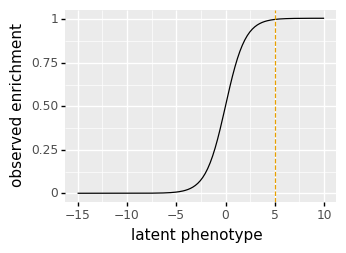

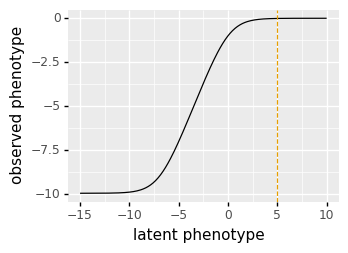

In [16]:
for value in ["enrichment", "phenotype"]:
    p = p_sim_h1.plotLatentVsObserved(value)
    _ = p.draw()

... and the second homolog:

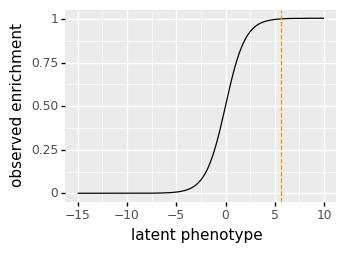

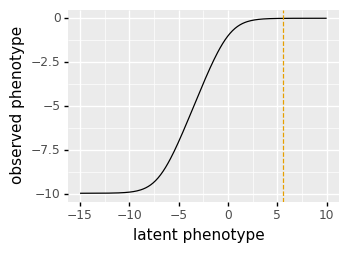

In [17]:
for value in ["enrichment", "phenotype"]:
    p = p_sim_h2.plotLatentVsObserved(value)
    _ = p.draw()

Show example data for variants for the first homolog.

In [18]:
v1_df.head()

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment
0,lib_1,AAAAAAATTTACGCGA,1,TTA18GTC TTA23TCA TTT41AAC,L18V L23S F41N,3,3,-15.608947,-9.965543,0.001000
1,lib_1,AAAAAACATAGGAGTA,3,TGC19AAG CGG29TCC,C19K R29S,2,2,2.516825,-0.102192,0.931616
2,lib_1,AAAAAAGAGGTTAAAC,1,ATG32TTC,M32F,1,1,3.980341,-0.016995,0.988289
3,lib_1,AAAAAAGGCTTATACT,1,TCA11TCG CGG12GGT GGT46AAA,R12G G46K,3,2,-21.146126,-9.965783,0.001000
4,lib_1,AAAAAATCACTAATAT,3,AGA1ACA CGT15CCG TCC37GCT AGT40TAA TCG42AGC,R1T R15P S37A S40*,5,4,-21.623836,-9.965784,0.001000


## The below code is me doing reality checks. Could think about making this more interpretable.

Show data for a mutation with identical effects between homologs.

In [19]:
mutation = 'R1D'
beta_h1 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h1'])
beta_h2 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h2'])
print('simulated latent phenotype:')
print('h1', round(beta_h1 + p_sim_h1.wt_latent, 2))
print('h2', round(beta_h2 + p_sim_h2.wt_latent, 2))
print('\ndata from single-mutant variants:')
display(v1_df[
    (v1_df['n_aa_substitutions'] == 1) &
    (v1_df['aa_substitutions'].str.contains(mutation))
].head(n=1))
display(v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1))

simulated latent phenotype:
h1 -2.46
h2 -1.85

data from single-mutant variants:


,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment
4350,lib_1,AGTACAATTGCATGAC,3,AGA1GAT,R1D,1,1,-2.458668,-3.639199,0.080259


,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment
4350,lib_1,AGTACAATTGCATGAC,3,AGA1GAT,R1D,1,1,-1.845728,-2.860021,0.137736


Show data for a mutation with a shifted effect at a site that is identical between homologs.

In [20]:
mutation = 'V3W'
beta_h1 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h1'])
beta_h2 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h2'])
print('simulated latent phenotype:')
print('h1', round(beta_h1 + p_sim_h1.wt_latent, 2))
print('h2', round(beta_h2 + p_sim_h2.wt_latent, 2))
print('\ndata from single-mutant variants:')
display(v1_df[
    (v1_df['n_aa_substitutions'] == 1) &
    (v1_df['aa_substitutions'].str.contains(mutation))
].head(n=1))
display(v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1))

simulated latent phenotype:
h1 7.05
h2 10.45

data from single-mutant variants:


,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment
4615,lib_1,AGTTACCCCGCTTTTT,2,GTG3TGG AGT40TCG,V3W,2,1,7.046597,0.008425,1.005857


,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment
16747,lib_1,GGGTCCCCACTACTCA,3,GTG3TGG,V3W,1,1,10.445533,0.00521,1.003618


Show data for a mutation with a shifted effect at a site that is non-identical between homologs.

In [21]:
mutation = 'K17A'
v2_df = variants_h2.barcode_variant_df
v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1)

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment
2224,lib_1,ACCGGCATTTTCGCTT,3,AAG17GCC,K17A,1,1,7.209132,0.004186,1.002905


In [22]:
mut_effects_df[
    mut_effects_df['mutation'].isin(['I17K', 'I17A'])
]

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,aaseq_h1,aaseq_h2
320,I17A,0.346554,I,17,A,True,1.182357,1.528911,I,K
327,I17K,2.563328,I,17,K,True,-2.630611,-0.067283,I,K


In [23]:
p_sim_h2.wt_latent - (-0.067283) + 1.528911

7.209133034778654

In [24]:
mutation = 'I17A'
beta_h1 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h1'])
beta_h2 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h2'])
print('simulated latent phenotype:')
print('h1', round(beta_h1 + p_sim_h1.wt_latent, 2))
#print('h2', round(beta_h2 + p_sim_h2.wt_latent, 2))
print('\ndata from single-mutant variants:')
display(v1_df[
    (v1_df['n_aa_substitutions'] == 1) &
    (v1_df['aa_substitutions'].str.contains(mutation))
].head(n=1))
display(v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1))

simulated latent phenotype:
h1 5.35

data from single-mutant variants:


,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment
2224,lib_1,ACCGGCATTTTCGCTT,3,ATC17GCC,I17A,1,1,5.346554,0.002828,1.001962


,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment


In [25]:
mutation = 'I17K'
beta_h1 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h1'])
beta_h2 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h2'])
print('simulated latent phenotype:')
print('h1', round(beta_h1 + p_sim_h1.wt_latent, 2))
#print('h2', round(beta_h2 + p_sim_h2.wt_latent, 2))
print('\ndata from single-mutant variants:')
display(v1_df[
    (v1_df['n_aa_substitutions'] == 1) &
    (v1_df['aa_substitutions'].str.contains(mutation))
].head(n=1))
display(v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1))

simulated latent phenotype:
h1 7.56

data from single-mutant variants:


,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment
1250,lib_1,AATAAGTGGGATATCG,2,ATC17AAG,I17K,1,1,7.563328,0.008931,1.006209


,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment


Show data for a mutation to the same amino acid at a site that is has no shifted mutational effects and is non-identical between homologs.

In [26]:
mutation = 'V2F'
v2_df = variants_h2.barcode_variant_df
v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1)

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment
366,lib_1,AAATAGGCGAGGAGGT,1,GTA2TTC,V2F,1,1,2.402038,-0.119652,0.92041


In [27]:
mut_effects_df[
    mut_effects_df['mutation'].isin(['S2V', 'S2F'])
]

,mutation,beta_h1,wt_aa,site,mut_aa,shifted_site,shift,beta_h2,aaseq_h1,aaseq_h2
24,S2F,-2.027543,S,2,F,False,0.0,-2.027543,S,V
36,S2V,1.183358,S,2,V,False,0.0,1.183358,S,V


In [28]:
p_sim_h2.wt_latent + p_sim_h2.muteffects['V2F']

2.4020378604533086

In [29]:
mutation = 'S2F'
beta_h1 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h1'])
beta_h2 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h2'])
print('simulated latent phenotype:')
print('h1', round(beta_h1 + p_sim_h1.wt_latent, 2))
#print('h2', round(beta_h2 + p_sim_h2.wt_latent, 2))
print('\ndata from single-mutant variants:')
display(v1_df[
    (v1_df['n_aa_substitutions'] == 1) &
    (v1_df['aa_substitutions'].str.contains(mutation))
].head(n=1))
display(v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1))

simulated latent phenotype:
h1 2.97

data from single-mutant variants:


,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment
366,lib_1,AAATAGGCGAGGAGGT,1,TCC2TTC,S2F,1,1,2.972457,-0.062254,0.957766


,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment


In [30]:
# Plot global-epistasis curves
# Make easier?

# Run through today
# Push
# Jared look over code

# Small test case
# Big test case

Question for Jesse:
* Say have two homologs separated by five mutations. Say have h1 + mutations that go to h2. Or have h2 + mutations that go to h1. In one case we'd add shifts, and in the other case we wouldn't. Problem?

In [33]:
len(v1_df.query("library == 'lib_1'").barcode.unique()) == len(v1_df.query("library == 'lib_1'"))

True

In [34]:
v1_df.head()

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment
0,lib_1,AAAAAAATTTACGCGA,1,TTA18GTC TTA23TCA TTT41AAC,L18V L23S F41N,3,3,-15.608947,-9.965543,0.001000
1,lib_1,AAAAAACATAGGAGTA,3,TGC19AAG CGG29TCC,C19K R29S,2,2,2.516825,-0.102192,0.931616
2,lib_1,AAAAAAGAGGTTAAAC,1,ATG32TTC,M32F,1,1,3.980341,-0.016995,0.988289
3,lib_1,AAAAAAGGCTTATACT,1,TCA11TCG CGG12GGT GGT46AAA,R12G G46K,3,2,-21.146126,-9.965783,0.001000
4,lib_1,AAAAAATCACTAATAT,3,AGA1ACA CGT15CCG TCC37GCT AGT40TAA TCG42AGC,R1T R15P S37A S40*,5,4,-21.623836,-9.965784,0.001000


In [35]:
v2_df.head()

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment
0,lib_1,AAAAAAATTTACGCGA,1,TTA18GTC CGC23TCC TTT41AAC,L18V R23S F41N,3,3,-16.334070,-9.965668,0.001000
1,lib_1,AAAAAACATAGGAGTA,3,TGC19AAG CGG29TCC,C19K R29S,2,2,0.589252,-0.630627,0.645896
2,lib_1,AAAAAAGAGGTTAAAC,1,ATG32TTC,M32F,1,1,4.593280,-0.009260,0.993602
3,lib_1,AAAAAAGGCTTATACT,1,TCA11TCG CGG12GGT GGT46AAA,R12G G46K,3,2,-20.533187,-9.965783,0.001000
4,lib_1,AAAAAATCACTAATAT,3,AGA1ACA CGT15CCG TCC37GCT AAG40TAA CAC42AGC,R1T R15P S37A K40* H42S,5,5,-18.897776,-9.965775,0.001000


In [45]:
v1_df = v1_df.assign(homolog="reference")
v2_df = v2_df.assign(homolog="H2")
simulated_dataset = pd.concat([v1_df, v2_df])

In [46]:
simulated_dataset

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,latent_phenotype,observed_phenotype,observed_enrichment,homolog
0,lib_1,AAAAAAATTTACGCGA,1,TTA18GTC TTA23TCA TTT41AAC,L18V L23S F41N,3,3,-15.608947,-9.965543,0.001000,reference
1,lib_1,AAAAAACATAGGAGTA,3,TGC19AAG CGG29TCC,C19K R29S,2,2,2.516825,-0.102192,0.931616,reference
2,lib_1,AAAAAAGAGGTTAAAC,1,ATG32TTC,M32F,1,1,3.980341,-0.016995,0.988289,reference
3,lib_1,AAAAAAGGCTTATACT,1,TCA11TCG CGG12GGT GGT46AAA,R12G G46K,3,2,-21.146126,-9.965783,0.001000,reference
4,lib_1,AAAAAATCACTAATAT,3,AGA1ACA CGT15CCG TCC37GCT AGT40TAA TCG42AGC,R1T R15P S37A S40*,5,4,-21.623836,-9.965784,0.001000,reference
...,...,...,...,...,...,...,...,...,...,...,...
49995,lib_2,TTTTTGTTCTCAACAG,2,ATA16GAG GCT39AAT CCA44GAA,I16E A39N P44E,3,3,-11.059277,-9.943194,0.001016,H2
49996,lib_2,TTTTTTCCACTTTACC,4,GGT46TCA,G46S,1,1,-1.222372,-2.125815,0.229122,H2
49997,lib_2,TTTTTTCTCTAGCTCA,3,AAA14ACG ATA16CGG AAC21CGG CCT24GGA ATC33CAC,K14T I16R N21R P24G I33H,5,5,-21.241232,-9.965783,0.001000,H2
49998,lib_2,TTTTTTCTTTATCTCT,3,GCT7TAC AAC20TCG GAC22GGG ATG31GCG GAC38TCT GC...,A7Y N20S D22G M31A D38S A39N G46P,7,7,-35.439788,-9.965784,0.001000,H2


In [47]:
! mkdir results

mkdir: cannot create directory ‘results’: File exists


In [48]:
simulated_dataset.to_csv(f"results/simulated_dataset_v1.csv", index=False)

In [49]:
geneseq_h1

'AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGTTTTTCGACTCCAGTAGGTTTACGCTCAGGA'

In [50]:
geneseq_h2

'AGAGTAGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTATAAAGTTATGCAACAACGACCGCCCTATCCGCAACATCCGGACAATGATGATCGAACACAACTCCGACGCTAAGTTTCACACTCCATATGGTTTAGACTCAGGA'

In [51]:
homolog_seqs

{1: 'RSVILRAYTNSRVKRVILCNNDLPIRNIRLMMILHNSDASFSTPVGLRSG',
 2: 'RVVILRAYTNSRVKRIKLCNNDRPIRNIRTMMIEHNSDAKFHTPYGLDSG'}

In [52]:
import json
help(json.dump)

Help on function dump in module json:

dump(obj, fp, *, skipkeys=False, ensure_ascii=True, check_circular=True, allow_nan=True, cls=None, indent=None, separators=None, default=None, sort_keys=False, **kw)
    Serialize ``obj`` as a JSON formatted stream to ``fp`` (a
    ``.write()``-supporting file-like object).
    
    If ``skipkeys`` is true then ``dict`` keys that are not basic types
    (``str``, ``int``, ``float``, ``bool``, ``None``) will be skipped
    instead of raising a ``TypeError``.
    
    If ``ensure_ascii`` is false, then the strings written to ``fp`` can
    contain non-ASCII characters if they appear in strings contained in
    ``obj``. Otherwise, all such characters are escaped in JSON strings.
    
    If ``check_circular`` is false, then the circular reference check
    for container types will be skipped and a circular reference will
    result in an ``RecursionError`` (or worse).
    
    If ``allow_nan`` is false, then it will be a ``ValueError`` to
    seriali

In [53]:
import json
json.dump(homolog_seqs, open("results/homolog_aa_seqs.json", "w"))